In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split



In [2]:
data=[]
with open("E:\EdgeAi\WISDM_ar_latest\WISDM_ar_v1.1\WISDM_ar_v1.1_raw.txt",'r')as file:
    for line in file:
        parts=line.strip().split(',')
        if len(parts)==6:
            try:
                user=int(parts[0])
                activity=parts[1]
                timestamp=int(parts[2])
                x=float(parts[3])
                y=float(parts[4])
                z_str = parts[5].replace(';', '')    
                z = float(z_str)
                data.append([user, activity, timestamp, x, y, z])
            except:
                continue      

df=pd.DataFrame(data, columns=['user', 'activity', 'timestamp', 'x', 'y', 'z'])

df.to_csv('wisdm_cleaned.csv', index=False)
df.head(800)

    
      
 

,user,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
795,33,Walking,49415992264000,-0.612916,3.568531,-1.797886
796,33,Walking,49416042129000,-0.803601,8.689782,-0.694638
797,33,Walking,49416152298000,1.688923,11.264028,-0.422231
798,33,Walking,49416252273000,1.225831,15.050485,-0.272407


Unique Activities: ['Jogging' 'Walking' 'Upstairs' 'Downstairs' 'Sitting' 'Standing']
Dataset Shape: (1086465, 6)


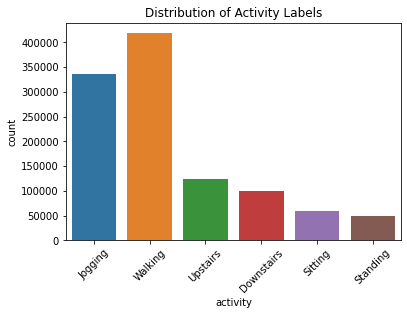

In [3]:

print("Unique Activities:", df['activity'].unique())
print("Dataset Shape:", df.shape)

sns.countplot(data=df, x='activity')
plt.xticks(rotation=45)
plt.title("Distribution of Activity Labels")
plt.show()


In [4]:
#add Magnitude feature
df['magnitude'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)


In [5]:
df

,user,activity,timestamp,x,y,z,magnitude
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,12.709551
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,12.365693
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,11.936562
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,18.751973
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,14.139804
...,...,...,...,...,...,...,...
1086460,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,9.290910
1086461,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,9.319125
1086462,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,9.338463
1086463,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,9.280329


In [6]:
#Convert activity to activity_code(string to int)

le = LabelEncoder()
df['activity_code'] = le.fit_transform(df['activity'])

activity_labels = dict(enumerate(le.classes_))

print("Activity Labels:", activity_labels)


Activity Labels: {0: 'Downstairs', 1: 'Jogging', 2: 'Sitting', 3: 'Standing', 4: 'Upstairs', 5: 'Walking'}


In [7]:

window_size = 60 
step_size = 20

segments = []
labels = []

for start in range(0, len(df) - window_size, step_size):
    end = start + window_size
    segment = df.iloc[start:end]
    if len(segment['activity_code'].unique()) == 1:
        x = segment['x'].values
        y = segment['y'].values
        z = segment['z'].values
        magnitude = segment['magnitude'].values

        segments.append([x, y, z, magnitude])
        labels.append(segment['activity_code'].iloc[0])

segments = np.asarray(segments)
labels = np.asarray(labels)

X = np.transpose(segments, (0, 2, 1))  # (num_samples, 60, 4)
y = labels
print(f"Segments shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Segments shape: (53188, 60, 4)
Labels shape: (53188,)


In [8]:
scaler = StandardScaler()
num_samples, timesteps, num_features = X.shape

X_reshaped = X.reshape(-1, num_features)
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(num_samples, timesteps, num_features)


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [11]:
num_classes = len(np.unique(y_train))

y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)


In [12]:
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# Flatten و Dense
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


C:\Users\sheydameh\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [14]:
history = model.fit(X_train, y_train_cat,
                    epochs=100,
                    batch_size=64,
                    validation_data=(X_test, y_test_cat))


Epoch 1/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7191 - loss: 0.7844 - val_accuracy: 0.8484 - val_loss: 0.3572
Epoch 2/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8446 - loss: 0.4154 - val_accuracy: 0.8870 - val_loss: 0.2817
Epoch 3/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8660 - loss: 0.3514 - val_accuracy: 0.9138 - val_loss: 0.2303
Epoch 4/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8832 - loss: 0.3207 - val_accuracy: 0.9316 - val_loss: 0.2027
Epoch 5/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8954 - loss: 0.2771 - val_accuracy: 0.9353 - val_loss: 0.1877
Epoch 6/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9028 - loss: 0.2685 - val_accuracy: 0.9422 - val_loss: 0.1744
Epoch 7/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9114 - loss: 0.2407 - val_accuracy: 0.9482 - val_loss: 0.1575
Epoch 8/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9113 - loss: 0.2370 - val_a

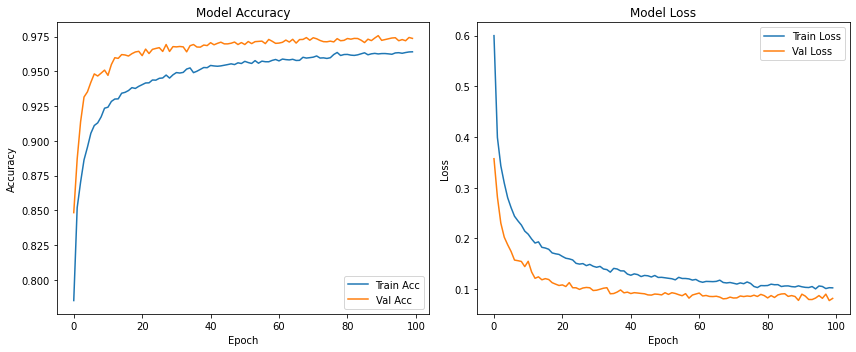

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
y_predic= model.predict(X_test)

print(y_predic.shape)


333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(10638, 6)


In [17]:
print(y_test_cat.shape)

(10638, 6)


In [18]:


from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test_cat, y_predic)
print(mse)


0.006626123967432725


In [19]:
mse = model.evaluate(X_test, y_test_cat)


333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9729 - loss: 0.0865


In [20]:
y_predic = np.array(y_predic)
print(y_predic)

[[4.2213548e-02 2.4521628e-03 1.6840094e-13 3.0820837e-30 9.5501792e-01
  3.1635186e-04]
 [1.3121313e-37 0.0000000e+00 1.0000000e+00 0.0000000e+00 6.9902074e-25
  3.5825438e-31]
 [1.6491324e-20 2.2213328e-11 0.0000000e+00 0.0000000e+00 3.0671236e-13
  1.0000000e+00]
 ...
 [2.1797641e-06 1.1054358e-06 6.7951420e-20 1.5343566e-25 2.1381043e-03
  9.9785858e-01]
 [7.5465509e-09 2.8414768e-13 2.2570551e-03 9.9770230e-01 4.0615203e-05
  3.2792101e-08]
 [1.4012142e-05 2.9790669e-06 9.8232791e-23 0.0000000e+00 2.6661203e-06
  9.9998033e-01]]


In [21]:
import numpy as np

y_pred_labels = np.argmax(y_predic, axis=1)
print(y_pred_labels)

[4 2 5 ... 5 3 5]


In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("activity_model.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\SHEYDA~1\AppData\Local\Temp\tmphijx_8r_\assets


INFO:tensorflow:Assets written to: C:\Users\SHEYDA~1\AppData\Local\Temp\tmphijx_8r_\assets


Saved artifact at 'C:\Users\SHEYDA~1\AppData\Local\Temp\tmphijx_8r_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 60, 4), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2887582670688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2887582753888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2887581782608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2887581782256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2887581885536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2887581885184: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [23]:
interpreter = tf.lite.Interpreter(model_path="activity_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

sample_input = X_test[1:2].astype(np.float32) 

interpreter.set_tensor(input_details[0]['index'], sample_input)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])

print("Predicted probabilities:", output)
print("Predicted class:", np.argmax(output))


Predicted probabilities: [[1.3121510e-37 0.0000000e+00 1.0000000e+00 0.0000000e+00 6.9902597e-25
  3.5825431e-31]]
Predicted class: 2


In [24]:
y_test_cat[1:2]

array([[0., 0., 1., 0., 0., 0.]])

## Test model with mobile's real data

In [25]:
import json
import numpy as np
import pandas as pd

def process_json_to_csv(input_path, output_path):
    with open("E:\EdgeAi\data2.json", 'r') as f:
        data = json.load(f)

    sensor_names = [s["name"] for s in data["payload"]["sensors"]]  # ['accX','accY','accZ']
    values = data["payload"]["values"]  # لیست از لیست‌های [x,y,z]

    df = pd.DataFrame(values, columns=sensor_names)

    df["magnitude"] = np.sqrt(df["accX"]**2 + df["accY"]**2 + df["accZ"]**2)

    df.to_csv(output_path, index=False)
    print(f"Saved CSV to {output_path}")

process_json_to_csv("data2.json", "data2.csv")


Saved CSV to data2.csv


In [27]:
df.head()

,accX,accY,accZ,magnitude
0,-0.1,0.0,9.9,9.900505
1,-0.1,0.0,9.9,9.900505
2,-0.1,-0.1,9.9,9.901010
3,-0.1,0.0,9.9,9.900505
4,-0.1,0.0,9.9,9.900505


In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

csv_path = 'data2.csv'

df = pd.read_csv(csv_path)

features = df[['accX', 'accY', 'accZ', 'magnitude']].values

expected_timesteps = 60
if features.shape[0] > expected_timesteps:
    features = features[:expected_timesteps]
elif features.shape[0] < expected_timesteps:
    pad = np.zeros((expected_timesteps - features.shape[0], features.shape[1]))
    features = np.vstack((features, pad))

scaler = StandardScaler()
features = scaler.fit_transform(features)

input_tensor = np.expand_dims(features, axis=0).astype(np.float32)

interpreter = tf.lite.Interpreter(model_path="activity_model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], input_tensor)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])


predicted_class = np.argmax(output)
activity_labels = {
    0: "Downstairs",
    1: "Jogging",
    2: "Sitting",
    3: "Standing",
    4: "Upstairs",
    5: "Walking"
}

print("Predicted probabilities:", output)
print("Predicted class:", predicted_class)
print("Predicted activity:", activity_labels[predicted_class])


Predicted probabilities: [[5.1271455e-13 7.0559014e-05 0.0000000e+00 0.0000000e+00 4.6906140e-17
  9.9992943e-01]]
Predicted class: 5
Predicted activity: Walking
